In [ ]:
import statsmodels.tsa.api as smtsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore") 
import sklearn as sk
from sklearn.model_selection import train_test_split
import pandas as pd
import math as math
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as skm
import sklearn.preprocessing as skp
import seaborn as sns 
import itertools as it
import torch
from torch.autograd import Variable
%matplotlib inline 

In [ ]:
def custom_data_prep(data, window):
    x = []
    y = []

    for i in range(len(data)-window-1):
        _x = data[i:(i+window)]
        _y = data[i+window]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [ ]:
airline_data_df = pd.read_csv("AirPassengers.csv")
airline_data_df.head(5)


,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [ ]:
month = airline_data_df.Month.astype('datetime64[ns]')
airline_data_df_idxd = airline_data_df.drop(columns='Month')
airline_data_df_2 = airline_data_df_idxd.set_index(pd.to_datetime(month))
airline_data_df_2.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


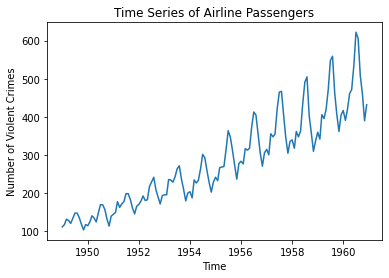

In [ ]:
plt.plot(airline_data_df_2)
plt.title("Time Series of Airline Passengers")
plt.xlabel("Time")
plt.ylabel("Number of Violent Crimes")
plt.show()

In [ ]:
#Scale the values between 0-1 as deep learning models can better interpret data.
scaler = skp.MinMaxScaler()
x_vals_scaled = scaler.fit_transform(airline_data_df_2.values)

window = 12

x, y = custom_data_prep(x_vals_scaled, window)



In [ ]:
#Scale the values between 0-1 as deep learning models can better interpret data.
scaler = skp.MinMaxScaler()
x_vals_scaled = scaler.fit_transform(airline_data_df_2.values)

window = 12

x, y = custom_data_prep(x_vals_scaled, window)

#split the data into train, validation and test splits.

x_train, x_rem, y_train, y_rem = train_test_split(x,y, train_size=0.82)

x_valid, x_test, y_valid, y_test = train_test_split(x_rem,y_rem, test_size=0.5)

print('Training set:', x_train.shape, y_train.shape)
print('Validation set:', x_valid.shape, y_valid.shape)
print('Testing set:', x_test.shape, y_test.shape)

#Convert the data into pytorch tensors, then into dataloader, this makes it easier for the LSTM to digest.

train_x = Variable(torch.Tensor(np.array(x_train)))
train_y = Variable(torch.Tensor(np.array(y_train)))

train_dataset = torch.utils.data.TensorDataset(train_x, train_y)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=107)

data_batch, target_batch = next(iter(trainloader))
print(data_batch.size())
print(target_batch.size())
print('Training Window:', data_batch[0])
print('Target:', target_batch[0])

val_x = Variable(torch.Tensor(np.array(x_valid)))
val_y = Variable(torch.Tensor(np.array(y_valid)))

val_dataset = torch.utils.data.TensorDataset(val_x, val_y)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=12)

data_batch, target_batch = next(iter(valloader))
print(data_batch.size())
print(target_batch.size())
print('Training Window:', data_batch[0])
print('Target:', target_batch[0])

test_x = Variable(torch.Tensor(np.array(x_test)))
test_y = Variable(torch.Tensor(np.array(y_test)))

test_dataset = torch.utils.data.TensorDataset(test_x, test_y)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=12)

test_data_batch, test_target_batch = next(iter(testloader))
print(test_data_batch.size())
print(test_target_batch.size())
print('Training Window:', test_data_batch[0])
print('Target:', test_target_batch[0])

Training set: (107, 12, 1) (107, 1)
Validation set: (12, 12, 1) (12, 1)
Testing set: (12, 12, 1) (12, 1)
torch.Size([107, 12, 1])
torch.Size([107, 1])
Training Window: tensor([[0.1042],
        [0.0560],
        [0.0193],
        [0.0695],
        [0.0792],
        [0.0888],
        [0.1429],
        [0.1139],
        [0.1313],
        [0.1429],
        [0.1834],
        [0.1834]])
Target: tensor([0.1544])
torch.Size([12, 12, 1])
torch.Size([12, 1])
Training Window: tensor([[0.0888],
        [0.1429],
        [0.1139],
        [0.1313],
        [0.1429],
        [0.1834],
        [0.1834],
        [0.1544],
        [0.1120],
        [0.0811],
        [0.1197],
        [0.1293]])
Target: tensor([0.1467])
torch.Size([12, 12, 1])
torch.Size([12, 1])
Training Window: tensor([[0.5830],
        [0.5637],
        [0.6100],
        [0.7104],
        [0.8571],
        [0.8784],
        [0.6931],
        [0.5849],
        [0.4981],
        [0.5811],
        [0.6042],
        [0.5541]])
Target: t

In [ ]:
class LSTM(torch.nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        #num_classes = output dimension, num_layers = amount of LSTM layers stacked, input_size = input data dimension (window size), hidden_size = hidden neurons per layer.
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = window
        #PyTorch LSTM module
        self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        #PyTorch linear layer for output
        self.fc = torch.nn.Linear(hidden_size, num_classes)
    #forward pass of cell and hidden state
    def forward(self, x):
      #hidden state output
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        #cell output
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [ ]:
input_size = 1
hidden_size = 12
num_layers = 1
output_size = 1

lstm_model = LSTM(output_size, input_size, hidden_size, num_layers)
loss = torch.nn.MSELoss()
optim = torch.optim.Adam(lstm_model.parameters(), lr=0.01)
print(lstm_model)

LSTM(
  (lstm): LSTM(1, 12, batch_first=True)
  (fc): Linear(in_features=12, out_features=1, bias=True)
)


In [ ]:
epochs = 150
train_loss = []
val_loss = []
for i in range(epochs):

  #training loop
  
  lstm_model.train()
  for x,y in trainloader:

    optim.zero_grad()  

    y_pred = lstm_model(x)

    single_loss = loss(y_pred, y)
    single_loss.backward()
    optim.step()

    train_loss.append(single_loss.item())

    if i%25 == 1:
        print(f'epoch: {i:3} train_loss: {single_loss.item():10.8f}')

  
  lstm_model.eval()
  for x,y in valloader:

    optim.zero_grad()  

    y_pred = lstm_model(x)

    single_loss = loss(y_pred, y)
    single_loss.backward()
    optim.step()

    val_loss.append(single_loss.item())

    if i%25 == 1:
        print(f'epoch: {i:3}val_ loss: {single_loss.item():10.8f}')

epoch:   1 train_loss: 0.06355601
epoch:   1val_ loss: 0.02034262
epoch:  26 train_loss: 0.00859149
epoch:  26val_ loss: 0.00614362
epoch:  51 train_loss: 0.00742980
epoch:  51val_ loss: 0.00469598
epoch:  76 train_loss: 0.00545457
epoch:  76val_ loss: 0.00338427
epoch: 101 train_loss: 0.00330313
epoch: 101val_ loss: 0.00238886
epoch: 126 train_loss: 0.00162369
epoch: 126val_ loss: 0.00124941


[0.10732118785381317, 0.063556008040905, 0.037311092019081116, 0.03456709161400795, 0.03260384127497673, 0.03000658005475998, 0.03135065361857414, 0.032561562955379486, 0.030445680022239685, 0.02437450923025608, 0.016724154353141785, 0.012353119440376759, 0.010330228134989738, 0.009516746737062931, 0.012906086631119251, 0.011760520748794079, 0.011259631253778934, 0.009135114029049873, 0.009528076276183128, 0.010122746229171753, 0.009603487327694893, 0.009056797251105309, 0.008719970472157001, 0.008556393906474113, 0.008795666508376598, 0.00886488426476717, 0.0085914870724082, 0.008387625217437744, 0.008244745433330536, 0.008393248543143272, 0.008531330153346062, 0.00838297326117754, 0.0081797419115901, 0.008100085891783237, 0.008177314884960651, 0.0082729272544384, 0.008182707242667675, 0.0080157071352005, 0.007953491993248463, 0.008019224740564823, 0.008081886917352676, 0.008006488904356956, 0.00786503218114376, 0.0077867223881185055, 0.007788598537445068, 0.00778712285682559, 0.00771

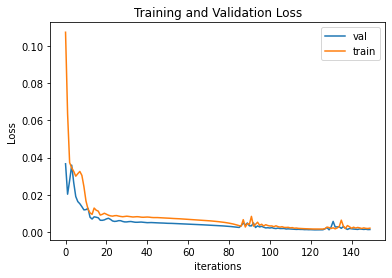

In [ ]:
print(train_loss)
plt.title("Training and Validation Loss")
plt.plot(val_loss,label="val")
plt.plot(train_loss,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:

for x_test,y_test in testloader:
  lstm_model.eval()
  y_test_pred = lstm_model(x_test)

print(y_test_pred)


tensor([[0.6006],
        [0.6118],
        [0.6187],
        [0.6021],
        [0.6137],
        [0.6442],
        [0.6619],
        [0.7112],
        [0.7846],
        [0.8009],
        [0.7515],
        [0.7138]], grad_fn=<AddmmBackward0>)


(12, 1)
[[415.08942]
 [420.9244 ]
 [424.4743 ]
 [415.87405]
 [421.87628]
 [437.67828]
 [446.85858]
 [472.37643]
 [510.42264]
 [518.87665]
 [493.27527]
 [473.7545 ]]


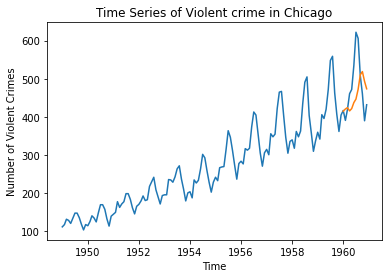

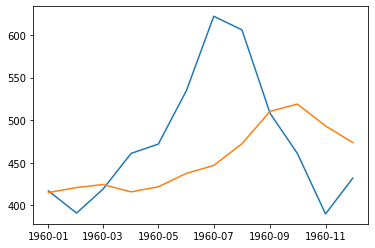

In [ ]:
data_predict = y_test_pred.data.numpy()
print(data_predict.shape)


predictions_rescaled = scaler.inverse_transform(data_predict)
print(predictions_rescaled)

df = pd.DataFrame(predictions_rescaled, index=airline_data_df_2.index[132:])

fig, ax = plt.subplots()
ax.plot(airline_data_df_2)
ax.plot(df)
plt.title("Time Series of Airline Passengers")
plt.xlabel("Time")
plt.ylabel("Number of Passengers")
plt.show()

fig, ax = plt.subplots()
ax.plot(airline_data_df_2.index[132:], airline_data_df_2['#Passengers'][132:])
plt.plot(df)
plt.show()

In [ ]:
test_y_rescaled = scaler.inverse_transform(test_y)

rmse = skm.mean_squared_error(test_y_rescaled, data_predict, squared = False)
print("Mean squared error for 12 forecast steps:", rmse)
mape = skm.mean_absolute_percentage_error(test_y_rescaled, data_predict)
print("Mean absolute percentage error for 12 forecast steps:", mape)

Mean squared error for 12 forecast steps: 479.31638922049785
Mean absolute percentage error for 12 forecast steps: 0.9985518778532595
